# Multilingual Sentences Grouping

The target of this notebook is to match question-answer pairs across languages, by assigning a "faq_id" on them. The data used is a CSV file with question-answer pairs in multi-language that is built in DataScrapping Stage.

The goal of this notebooke is to match question-answer pairs across _market_ (languages), group similar questions and assign a "faq_id" to each group

**Solution Overview**
1. Sentences level data
2. Embedding sentences with Multilingual Universal Sentence Encoder on Tensorflow Hub (Transfer Learning)
3. Computing sentence level semantic similarity with embeddings vectors
4. Grouping the sentences

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Parameters-to-be-input-before-running" data-toc-modified-id="Parameters-to-be-input-before-running-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Parameters to be input before running</a></span></li><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Importion" data-toc-modified-id="Importion-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Importion</a></span></li><li><span><a href="#Overview" data-toc-modified-id="Overview-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Overview</a></span></li><li><span><a href="#No-need-to-process-data" data-toc-modified-id="No-need-to-process-data-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>No need to process data</a></span></li></ul></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><span><a href="#Embeddings" data-toc-modified-id="Embeddings-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Embeddings</a></span></li><li><span><a href="#Similarity" data-toc-modified-id="Similarity-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Similarity</a></span></li></ul></li><li><span><a href="#Grouping" data-toc-modified-id="Grouping-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Grouping</a></span><ul class="toc-item"><li><span><a href="#Kmean-Clustering" data-toc-modified-id="Kmean-Clustering-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Kmean Clustering</a></span></li><li><span><a href="#Custom-Grouping-Algorithm" data-toc-modified-id="Custom-Grouping-Algorithm-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Custom Grouping Algorithm</a></span></li></ul></li><li><span><a href="#Verify-results" data-toc-modified-id="Verify-results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Verify results</a></span></li><li><span><a href="#Save-result-to-csv" data-toc-modified-id="Save-result-to-csv-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Save result to csv</a></span></li><li><span><a href="#Next" data-toc-modified-id="Next-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Next</a></span></li></ul></div>

## Parameters to be input before running

In [1]:
input_file_path = '../data/extracted_n26_new.csv'
output_file_path = '../data/closest_matches.csv'
output_model_path = '../codes/closest_match_model.pkl'

## Import Libraries

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
# It takes around 10 seconds to load all the libraries

# Data Manipulation
import pandas as pd
import numpy as np
import random

# Modelling
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow.compat.v2 as tf
import tensorflow_hub as hub
from tensorflow_text import SentencepieceTokenizer
# from simpleneighbors import SimpleNeighbors
from copy import deepcopy

# Save model
import joblib

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt

## Data

### Summary

- Number of question-answer pairs: 1806
- After removing the duplicates question-answer pairs in section (3.2), we have total 1084 question-answer pairs.
- All questions come from 12 markets, scattered across seven countries (gb, at, es, fr, eu, it, de). 
- Since n26 has withdrawn from the gb market, we only collected a very small number of questions (less than 10). 
- The number of questions in de's market is generally a little more than other markets, as this is the main market of n26.

**No need to process data**

Universal Sentence Encoder takes greater-than-word length text, for instance, sentences, phrases, or short paragraphs. It does not require preprocessing the data as it performs best effort text input preprocessing inside the graph.

**The only thing we have to do is to define the training set:**

There are several options of input for modelling:
- questions: only use questions to train the model
- answers: only use answers to train the model. However, some answers have long paragraphs, I will test to put all in or only take first x paragraphs
- qas: combine questions and anwers together, but only take first x paragraphs in answers.

**We can also split data in different ways:**
- embed all questions together: the result shows that the similarity between questions in same language is always higher compared to other language with exactly same meaning
- split questions by languages and embed each language one by one: this match the purpose of the task, that we hope to build groups with only one question per market

### Importion

In [4]:
data_df = pd.read_csv(input_file_path, index_col=0)

In [5]:
data_df["locale"] = data_df['market'].apply(lambda x: x.split('-')[0])
data_df.rename(columns={'title':'question', 'content':'answer'}, inplace=True)

In [6]:
data_df = data_df[['locale', 'market', 'url', 'question', 'answer']].copy()

In [7]:
data_df.head(2)

,locale,market,url,question,answer
0,en,en-de,https://support.n26.com/en-de/cards/order-and-...,When will my card arrive?,Standard delivery takes up to 15 business days...
1,es,es-es,https://support.n26.com/es-es/pagos-transferen...,¿Se efectuará mi domiciliación si tengo pocos ...,Si tu saldo disponible no cubre el importe de ...


### Overview

We have 1844 question-answer pairs:

In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1844 entries, 0 to 1843
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   locale    1844 non-null   object
 1   market    1844 non-null   object
 2   url       1844 non-null   object
 3   question  1844 non-null   object
 4   answer    1844 non-null   object
dtypes: object(5)
memory usage: 86.4+ KB


- Almost all countries support English, so much more QAs in Engilsh. However, after removing the duplicated questions, QAs in English is just slight more than others.
- en-gb market has just been closed, so I can only get a little data
- There are some duplicated questions within same market. It is normal to have identical questions with same language, but not with same market. Need more investigation.

Text(0.5, 1.0, 'market without duplication')

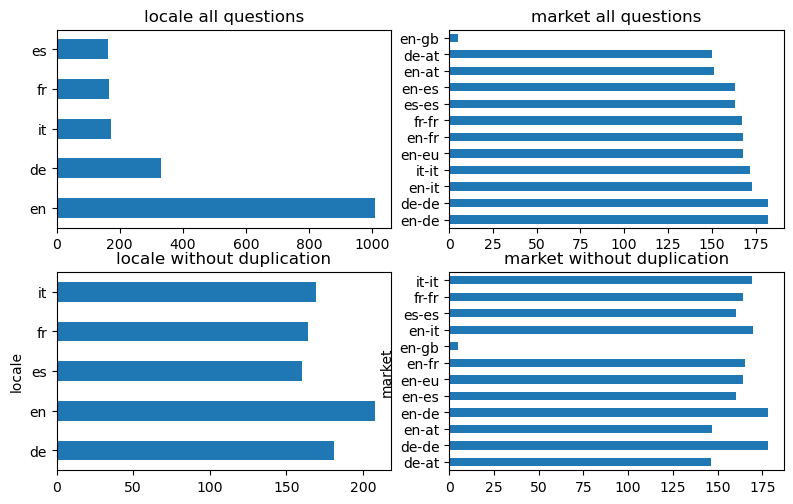

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))
fig.tight_layout() 
data_df['locale'].value_counts().plot(kind='barh', ax=axes[0, 0])
data_df['market'].value_counts().plot(kind='barh', ax=axes[0, 1])
data_df.groupby('locale')['question'].nunique().plot(kind='barh', ax=axes[1, 0])
data_df.groupby('market')['question'].nunique().plot(kind='barh', ax=axes[1, 1])
axes[0, 0].set_title('locale all questions')
axes[0, 1].set_title('market all questions')
axes[1, 0].set_title('locale without duplication')
axes[1, 1].set_title('market without duplication')

After visualizing the data, for duplicates market-question pairs within same market:
- they have slightly different urls. For example, different webpage versions (Android / Iphone) at the end of url
- they have different urls, but at the end all urls will direct to same page
For theses reasons, we can simply remove duplicates.

In [10]:
investigation = data_df[data_df.duplicated(['market', 'question'], keep=False)].sort_values(['market', 'question']).head()
for idx, row in investigation.iterrows():
    print(row.question)
    print(row.url)

Du bist Opfer eines Betrugs geworden? Kontaktiere uns.
https://support.n26.com/de-at/sicherheit/kontosicherheit/wurdest-du-ziel-eines-betrugs-kontaktiere-uns
Du bist Opfer eines Betrugs geworden? Kontaktiere uns.
https://support.n26.com/de-at/article/4eMoEDm6RGEhlqkwKgnMcJ
Wie kann ich meine Bestätigungs-PIN ändern?
https://support.n26.com/de-at/sicherheit/passwort-und-codes/wie-andere-ich-meine-bestatigungs-pin
Wie kann ich meine Bestätigungs-PIN ändern?
https://support.n26.com/de-at/sicherheit/passwort-und-codes/wie-andere-ich-meine-bestatigungs-pin?activeTab=android
Wie kann ich meine Bestätigungs-PIN ändern?
https://support.n26.com/de-at/sicherheit/passwort-und-codes/wie-andere-ich-meine-bestatigungs-pin?activeTab=iphone


In [11]:
print("Before:", len(data_df))
data_df.drop_duplicates(['market', 'question'], inplace=True)
print("After:", len(data_df))

Before: 1844
After: 1806


### No need to process data

In [12]:
questions_dict = data_df.groupby('market')['question'].unique().apply(list).to_dict()

In [13]:
questions_dict.keys()

dict_keys(['de-at', 'de-de', 'en-at', 'en-de', 'en-es', 'en-eu', 'en-fr', 'en-gb', 'en-it', 'es-es', 'fr-fr', 'it-it'])

## Modelling

### Embeddings

Multilingul Universal Setence Encoder modules on Tensorflow Hub are tested here.
- The modules provide a simple way for transfer learning to other NLP tasks. 
- The modules can encode texts in multilingual (at least 16 languages)
- The sentence embeddings tends to outperform word level transfer
- The performance is also good with minimal amounts of data which is a good fit for the task as we only have 18k rows. 

I have quickly tested 4 multilingual models in TensorFlow Hub:
1. universal-sentence-encoder-cmlm/multilingual-base: 
    - Universal sentence encoder for 100+ languages trained with conditional masked language model. 
    - https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1
    
2.  universal-sentence-encoder-multilingual 
    - 16 languages (Arabic, Chinese-simplified, Chinese-traditional, English, French, German, Italian, Japanese, Korean, Dutch, Polish, Portuguese, Spanish, Thai, Turkish, Russian) text encoder. 
    - https://tfhub.dev/google/universal-sentence-encoder-multilingual/3
    
3.  universal-sentence-encoder-multilingual-large 
    - 16 languages (Arabic, Chinese-simplified, Chinese-traditional, English, French, German, Italian, Japanese, Korean, Dutch, Polish, Portuguese, Spanish, Thai, Turkish, Russian) text encoder. 
    - https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3
    
4.  universal-sentence-encoder-multilingual-qa 
    - 16 languages (Arabic, Chinese-simplified, Chinese-traditional, English, French, German, Italian, Japanese, Korean, Dutch, Polish, Portuguese, Spanish, Thai, Turkish, Russian) question answer encoder. 
    - https://tfhub.dev/google/universal-sentence-encoder-multilingual-qa/3
    


**Encoder - universal-sentence-encoder-cmlm/multilingual-base**

The purpose of the task is to match similar questions in different languages, and I want to support as many language as possible, I decided to use the first module.

1. Call preprocessor module for text embeddings with Transformer encoders: uses a vocabulary for multilingual models extracted from the Wikipedia, CommonCrawl, and translation pairs from Web
2. Call universal-sentence-encoder-cmlm multilingual module with the output of previous step

The Encoder uses a BERT transformer backbone. Preprocessor allows to preprocessing plain text inputs into the input format expected by BERT.

In [14]:
# Module from Tensorflow Colab
# For semantic similarity tasks, apply l2 normalization to embeddings
def normalization(embeds):
    # 2-norm (largest sing. value) is used
    # keepdims=True so the axes which are normed over are left in the result as dimensions with size one
    norms = np.linalg.norm(embeds, 2, axis=1, keepdims=True)
    return embeds / norms

# Load preprocessor and encoder
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2"
)
encoder = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1"
)

Metal device set to: Apple M2


2022-11-25 09:16:13.738492: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-25 09:16:13.739082: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-11-25 09:16:15.987700: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-25 09:16:16.040176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [15]:
# Run the model from Macbook M2, specifies the device for ops created/executed 
with tf.device('/cpu:0'):
    # Dictionary with key = market and value = embeddings
    embeds_dict = {}
    for market, questions in questions_dict.items():
        sentences = tf.constant(questions)
        sentences_embeds = encoder(preprocessor(sentences))["default"]
        # For semantic similarity tasks, apply l2 normalization to embeddings
        sentences_embeds = normalization(sentences_embeds)
        embeds_dict[market] = deepcopy(sentences_embeds)

2022-11-25 09:17:57.565834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-25 09:17:57.747034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-25 09:18:09.592729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-25 09:18:09.719225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-25 09:18:24.104742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-25 09:18:24.233478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-25 09:18:51.033491: I tensorflow/core/grappler/optimizers/cust

### Similarity

Vectors then can be used for sentence similarity across multiple languages.

I compute the element-wise sum of the representations at each word position, and divide the sum by the square root of the length of the sentence. Therefore, there will have no setence lenght effect on this Encoder.

In [16]:
def calculate_similarity(embeddings_1, embeddings_2, labels_1, labels_2):
    """
    Calculate the similarity using arccos based text similarity
    of two high-dimensional vectors
    -------------------------
    Args:
        embeddings_1 (vector): embeddings produced by encoder
        embeddings_2: embeddings produced by encoder
        labels_1: texts in used for embeddings_1
        labels_2: texts in used for embeddings_2

    Returns:
        df (dataframe): a pandas dataframe with three columns: 
        (texts in embeddings_1, texts in embeddings_2, similarity between two texts)
    """

    # Check that embeddings and its labels have same length
    assert len(embeddings_1) == len(labels_1)
    assert len(embeddings_2) == len(labels_2)

    # Calculate similarity using arccos based text similarity (Yang et al. 2019; Cer et al. 2019)
    sim = 1 - np.arccos(cosine_similarity(embeddings_1, embeddings_2)) / np.pi

    # Compute similarity between two texts
    embeddings_1_col, embeddings_2_col, sim_col = [], [], []
    for i in range(len(embeddings_1)):
        for j in range(len(embeddings_2)):
            embeddings_1_col.append(labels_1[i])
            embeddings_2_col.append(labels_2[j])
            sim_col.append(sim[i][j])

    # Create final dataframe
    df = pd.DataFrame(zip(embeddings_1_col, embeddings_2_col, sim_col),
                      columns=['embeddings_1', 'embeddings_2', 'sim'])

    df = df.fillna(1)
    return df

## Grouping

I have tested two methods.

### Kmean Clustering
1. build similarity matrix with ```calculate_similarity```
2. use ```sklearn.cluster.KMeans``` with smilarity matrix as training data
3. use Elbow method to find the most optimal number of clusters

However, I have identified several problems when using this method:

- Problem 1: kmean might not be able to fullfill our requirements, which to have only one question per market in each group

- Problem 2: the similarity between the same language is relatively high
```
    Pourquoi le distributeur automatique a enregis...	5
    Pourquoi mon achat en ligne a-t-il échoué ?	5
    Pourquoi mon virement a échoué ?	5
    Pourquoi la liaison avec mon compte Wise a éch...
```

- Problem 3: Unable to find a suitable number of clusters
I can't get a smooth curve even when I double the number of clusters from 200 to 500.

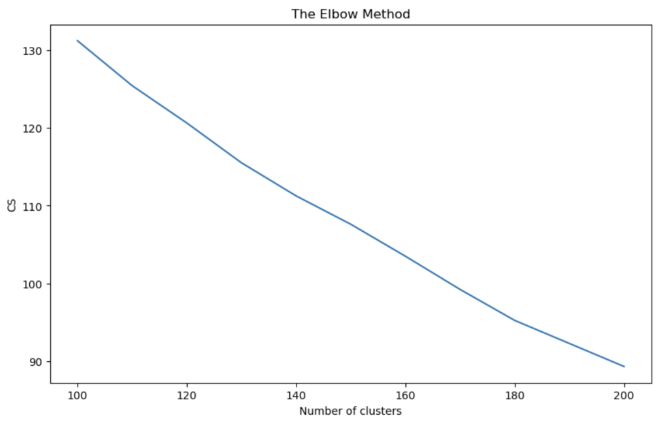

### Custom Grouping Algorithm

1. For every questions, get the most similar questions of each other market => q*(m-1)

In [17]:
final_group = {}
for market1 in questions_dict.keys():
    for market2 in questions_dict.keys():
        if market1 == market2:
            continue
            
        # Calculate the similarity
        similarity_df = calculate_similarity(embeds_dict[market1],
                                             embeds_dict[market2],
                                             questions_dict[market1],
                                             questions_dict[market2])
        
        # Get the most similar question
        similarity_df = similarity_df.fillna(0.1)
        similarity_df = similarity_df.groupby("embeddings_1").apply(
            lambda x: x.nlargest(1, ['sim'])).reset_index(drop=True) # only get 1
        
        # Build a diction of tuple {questions:{market, question_multilingul, similarity}}
        similarity_df['market'] = market2
        match_dict = [tuple(x) for x in similarity_df.values]
        match_dict = {t[0]:[t[1:]] for t in match_dict}
        
        # Update the final group (avoid duplicated questions)
        final_group = {
            key: final_group.get(key, []) + match_dict.get(key, [])
            for key in set(list(final_group.keys()) + list(match_dict.keys()))
        }

In [18]:
# Convert dictionary into a dataframe
L = [(k, *t) for k, v in final_group.items() for t in v]
final_group = pd.DataFrame(L, columns=['FAQ', 'question', 'similarity', 'market'])
final_group.drop_duplicates(['FAQ', 'question', 'market'], inplace=True)

In [19]:
final_group.head()

,FAQ,question,similarity,market
0,¿Cómo funcionan los pagos contactless?,Wie funktionieren kontaktlose Zahlungen?,0.848610,de-at
1,¿Cómo funcionan los pagos contactless?,Wie funktionieren kontaktlose Zahlungen?,0.848610,de-de
2,¿Cómo funcionan los pagos contactless?,How do contactless payments work?,0.897137,en-at
3,¿Cómo funcionan los pagos contactless?,How do contactless payments work?,0.897137,en-de
4,¿Cómo funcionan los pagos contactless?,How do contactless payments work?,0.897137,en-es


In [20]:
# Build the group

group = 1
question_group = pd.DataFrame({
    'question': [],
    'market': [],
    'similarity': [],
    'FAQ_id': []
})

# Start with question in English as FAQ (group name)
for market in [
        'en-at', 'en-de', 'en-es', 'en-eu', 'en-fr', 'en-gb', 'en-it', 'de-at',
        'de-de', 'es-es', 'fr-fr', 'it-it'
]:
    # Consider that every question can only be in one group
    for q in questions_dict[market]:
        if q in question_group['question'].unique():
            continue
        gp_df = final_group[final_group['FAQ'] == q]
        gp_df.loc['end', 'question'] = q
        gp_df.loc['end', 'market'] = market
        gp_df.loc['end', 'similarity'] = 1.0
        gp_df['FAQ_id'] = group
        question_group = pd.concat([question_group, gp_df])
        group += 1

In [21]:
question_group = question_group.sort_values('similarity').drop_duplicates(['question', 'market'], keep='last')

In [22]:
result_df = data_df.merge(question_group, how='left', on=['question', 'market'])

In [23]:
print('Number of groups:', result_df['FAQ_id'].nunique())

Number of groups: 325


Investigate questions without groups. It seems that questions without group don't have similar questions in other languages. So I simply create one new group per each question.

In [24]:
result_df[result_df['FAQ_id'].isnull()]

,locale,market,url,question,answer,similarity,FAQ_id,FAQ
112,de,de-de,https://support.n26.com/de-de/zahlungen-ueberw...,Wie erstelle und verwalte ich Daueraufträge?,Wenn du in der App oder im Online Banking eine...,NaN,NaN,NaN
118,en,en-fr,https://support.n26.com/en-fr/payments-transfe...,How to request a refund for a direct debit?,Refunding a direct debit does not cancel the c...,NaN,NaN,NaN
504,en,en-eu,https://support.n26.com/en-eu/payments-transfe...,How to request a refund for a direct debit?,Refunding a direct debit does not cancel the c...,NaN,NaN,NaN
526,en,en-eu,https://support.n26.com/en-eu/account-and-pers...,How to file a complaint?,Looking for support or have question?If you ne...,NaN,NaN,NaN
608,en,en-fr,https://support.n26.com/en-fr/account-and-pers...,How to file a complaint?,Looking for support or have a question?If you ...,NaN,NaN,NaN
657,en,en-at,https://support.n26.com/en-at/account-and-pers...,How to file a complaint?,Looking for support or have a question?If you ...,NaN,NaN,NaN
822,en,en-it,https://support.n26.com/en-it/payments-transfe...,How to request a refund for a direct debit?,Refunding a direct debit does not cancel the c...,NaN,NaN,NaN
971,en,en-it,https://support.n26.com/en-it/account-and-pers...,How to file a complaint?,Looking for support or have a question?If you ...,NaN,NaN,NaN
1120,en,en-es,https://support.n26.com/en-es/payments-transfe...,How to request a refund for a direct debit?,Refunding a direct debit does not cancel the c...,NaN,NaN,NaN
1135,en,en-de,https://support.n26.com/en-de/payments-transfe...,How to request a refund for a direct debit?,Refunding a direct debit does not cancel the c...,NaN,NaN,NaN


In [25]:
q = 'How to file a complaint?'
final_group[
    (final_group["question"]==q)].sort_values('similarity', ascending=False).head(20)

,FAQ,question,similarity,market
19575,How to file a complaint?,How to file a complaint?,0.999845,en-gb
19571,How to file a complaint?,How to file a complaint?,0.999754,en-de
19572,How to file a complaint?,How to file a complaint?,0.999754,en-es
19573,How to file a complaint?,How to file a complaint?,0.999754,en-eu
19574,How to file a complaint?,How to file a complaint?,0.999754,en-fr
19576,How to file a complaint?,How to file a complaint?,0.999754,en-it
19582,How to file a complaint?,How to file a complaint?,0.999754,en-at
5517,How to give feedback or suggest a new product?,How to file a complaint?,0.824682,en-gb
10665,Received a suspicious message?,How to file a complaint?,0.787188,en-gb
446,Have you been victim of a fraud? Contact us.,How to file a complaint?,0.781055,en-gb


In [26]:
for q in result_df[result_df['FAQ_id'].isnull()]['question'].unique():
    result_df.loc[result_df[result_df['question']==q].index.to_list(), 'FAQ_id'] = group
    group += 1

In [27]:
result_df = result_df[['FAQ_id', 'locale', 'market', 'question', 'answer']].copy()
result_df['FAQ_id'] = result_df['FAQ_id'].astype(int)

**Final results**

In [28]:
result_df.head(10)

,FAQ_id,locale,market,question,answer
0,9,en,en-de,When will my card arrive?,Standard delivery takes up to 15 business days...
1,228,es,es-es,¿Se efectuará mi domiciliación si tengo pocos ...,Si tu saldo disponible no cubre el importe de ...
2,196,es,es-es,¿Por qué me han cobrado por una domiciliación?,Las domiciliaciones devueltas por saldo insufi...
3,48,en,en-eu,"How to change my phone number, address, or oth...",It’s important to keep your personal data up t...
4,119,en,en-de,How to block contactless payments on my card?,Currently only available for iOS users on the ...
5,85,en,en-eu,Why can’t I see other N26 users on MoneyBeam?,To carry out real-time transactions such as Mo...
6,98,en,en-de,How to manage my visibility as an N26 user?,To grant you access to all our in-app features...
7,35,es,es-es,¿Cómo funcionan los pagos contactless?,Los pagos contactless (pestaña nueva) de tu ta...
8,117,es,es-es,¿Qué es el formulario web de N26 para solicitu...,Proteger los datos personales y financieros de...
9,76,es,es-es,¿Cómo puedo hacer de N26 mi cuenta principal?,Podemos ayudarte a convertir N26 en tu cuenta ...


## Verify results

A good model shall be able to demonstrate:
- All groups are with questions that are sematically similar
- All groups are with multi languages and market. Ideally, only one question per market.

To verify, we can :
- try a few different sample of groups

To have a deeper verification, we can use a supervised dataset with groups to calculate the accuracy.

In [29]:
questions_dict.keys()

dict_keys(['de-at', 'de-de', 'en-at', 'en-de', 'en-es', 'en-eu', 'en-fr', 'en-gb', 'en-it', 'es-es', 'fr-fr', 'it-it'])

In [30]:
FAQ_id = random.choice(result_df['FAQ_id'].unique())
result_df[result_df['FAQ_id']==FAQ_id]

,FAQ_id,locale,market,question,answer
103,159,es,es-es,¿Por qué tengo que enviar más documentos?,Cuando hayas iniciado el proceso de verificaci...
170,159,it,it-it,Perché devo inviare altri documenti?,Dopo aver avviato il processo di verifica per ...
260,159,fr,fr-fr,Pourquoi dois-je envoyer des documents supplém...,Une fois que vous avez commencé le processus d...
370,159,en,en-es,Why do I need to send additional documents?,Once you have started the verification process...
680,159,en,en-eu,Why do I need to send additional documents?,Once you have started the verification process...
732,159,en,en-fr,Why do I need to send additional documents?,Once you have started the verification process...
888,159,en,en-it,Why do I need to send additional documents?,Once you have started the verification process...
1256,159,de,de-de,Warum muss ich weitere Unterlagen schicken?,Sobald du den Verifizierungsprozess zur Eröffn...
1457,159,en,en-de,Why do I need to send additional documents?,Once you have started the verification process...


## Save result to csv

In [31]:
result_df.to_csv(output_file_path)

## Next
- Fine tuning the model:
    - test different similarity calcluation methods
    - try different dataset as mentioned in section 3, to see which one provides best result
- Test other Sentence Encoder methods, and compare the results to see which one could produce better result
- Build a Sequential Clustering model
- etc. There are many ways to enhance the results.